<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/projeto_final/fabio_mazza/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get dataset annotations

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip "/content/annotations_trainval2017.zip"

!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!unzip "/content/stuff_annotations_trainval2017.zip"

--2022-06-24 21:28:35--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.109.139
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.109.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  96.9MB/s    in 2.5s    

2022-06-24 21:28:38 (96.9 MB/s) - ‘annotations_trainval2017.zip.1’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import tqdm

from collections import OrderedDict

In [8]:
dataDir='/content'
dataType='image_info_test-dev2017'
annFile='{}/annotations/{}.json'.format(dataDir,dataType)

In [9]:
coco_annotation=COCO(annFile)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [22]:
# Category IDs.
cat_ids = coco_annotation.getCatIds()
len(cat_ids)
cats = coco_annotation.loadCats(cat_ids)
cats

[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 {'id': 17, 'name': 'cat', 'supercategory': 'animal'},
 {'id': 18, 'name': 'dog', 'supercategory': 'animal'},

In [17]:
cat_ids = coco_annotation.getCatIds()
len(cat_ids)
cats = coco_annotation.loadCats(cat_ids)
print(cats[20])

{'supercategory': 'animal', 'id': 22, 'name': 'elephant'}


In [24]:
cats = coco_annotation.loadCats([157])
cat_names = [cat["name"] for cat in cats]
print("Categories Names:")
print(cat_names)

Categories Names:
['sky-other']


In [46]:
img_ids = coco_annotation.getImgIds()
img_ids[29]
img_info = coco_annotation.loadImgs(img_ids[29])
img_ids[29]

79841

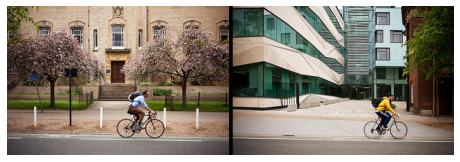

In [45]:
img_url = img_info[0]["coco_url"]
I = io.imread(img_url)
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
img_id = img_info[0]["id"]
ann_ids = coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
anns = coco_annotation.loadAnns(ann_ids)
print(f"Annotations for Image ID {img_id}:")
print(anns)

Annotations for Image ID 497160:
[{'segmentation': [[241.27, 37.95, 324.93, 68.77, 334.61, 78.46, 339.02, 102.23, 331.97, 179.72, 326.69, 201.73, 320.52, 212.3, 303.79, 229.91, 215.74, 286.27, 131.2, 333.82, 101.26, 344.38, 98.62, 332.94, 93.34, 331.18, 78.37, 339.1, 28.18, 267.78, 21.13, 258.09, 28.18, 249.28, 11.45, 230.79, 20.25, 218.46, 14.97, 160.35, 36.98, 134.81, 79.25, 100.47, 175.23, 55.56, 238.63, 37.07]], 'area': 67745.08085, 'iscrowd': 0, 'image_id': 497160, 'bbox': [11.45, 37.07, 327.57, 307.31], 'category_id': 80, 'id': 1128544}]
